In [33]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluate model predictions
### Select best predicted squad and compare gained points with average points from specific gameweek

In [34]:
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from src.data.data_loader import load_average_pts
from src.features.data_engineering import preprocess_seasons_data
from src.features.data_engineering import reverse_processing

from src.modeling.train_model import train_mlp_model
from src.modeling.predictions import merge_reversed_data_with_predictions
from src.modeling.evaluate_squad import squad_selection_without_constraints
from src.modeling.evaluate_squad import get_average_pts
from src.modeling.evaluate_squad import evaluate_selected_squad_without_constraints

In [35]:
average_pts = load_average_pts()

In [36]:
average_pts.head()

,GW,AVG_PTS_2016/17,AVG_PTS_2018/19,AVG_PTS_2021/22
0,1,44,53,69
1,2,56,59,56
2,3,40,48,54
3,4,41,43,57
4,5,47,46,55


## Load specific test gameweek data
**NOTE:** To properly evaluate model predictions comparing it with average points from specific gameweek, remember to leave performance sample of every player from specific gameweek in test dataset

In [37]:
test_subset = (['2016-17', [35,36,37]], ['2021-22', [27,28,29]])

(x_train, y_train), (x_test, y_test), (x_train_target, x_test_target), x_scaler = preprocess_seasons_data(random_split=False, test_subset=test_subset)

In [38]:
# preview unique values in 'season' and 'GW' columns from x_test_target
print(x_test_target.season.unique())
print(x_test_target.GW.unique())

['2016-17' '2021-22']
[35 36 37 27 28 29]


## Train MLP and XGBoost models on specific subset and save them

In [39]:
# model = tf.keras.models.Sequential()
#
# model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
# model.add(tf.keras.layers.Dense(units=256, activation='relu'))
# model.add(tf.keras.layers.Dense(units=256, activation='relu'))
# model.add(tf.keras.layers.Dense(units=126, activation='relu'))
# model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [40]:
# model_mlp = train_mlp_model(model, x_train, y_train)

In [41]:
# model_xgb = xgb.XGBRegressor()
# model_xgb.fit(x_train, y_train)

In [42]:
import os
root_dir = os.path.dirname(os.path.abspath(''))

In [43]:
# model_mlp.save(root_dir + '\\models\\baseline\\mlp_model_06-07-22.h5')
# model_xgb.save_model(root_dir + '\\models\\baseline\\xgb_model_06-07-22.json')

## Make predictions on specific test subset using MLP and XGBoost models

In [44]:
model_mlp = tf.keras.models.load_model(root_dir + '\\models\\baseline\\mlp_model_06-07-22.h5')
model_xgb = xgb.XGBRegressor()
model_xgb.load_model(root_dir + '\\models\\baseline\\xgb_model_06-07-22.json')

In [45]:
x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)

In [46]:
predictions_merged_mlp = merge_reversed_data_with_predictions(model_mlp, x_test, y_test, x_test_reversed)
predictions_merged_xgb = merge_reversed_data_with_predictions(model_xgb, x_test, y_test, x_test_reversed)

### Evaluate MLP model predictions without constraints for gameweek 27 in 2021-22 season
At this moment, I do not take price constraints into account.

In [47]:
# get data from predictions_merged only for 2021-22 season and gameweek 27
predictions_merged_27 = predictions_merged_mlp[(predictions_merged_mlp.season == '2021-22') & (predictions_merged_mlp.GW == 27)]
# sort predictions_merged_27 by predicted points in descending order
predictions_merged_27 = predictions_merged_27.sort_values(by='predicted_total_points_next_gameweek', ascending=False)

In [48]:
# get first row from predictions_merged_27 and double 'total_points_next_gameweek' value, because this player would be chosen as a capitan
predictions_merged_27.iloc[0, predictions_merged_27.columns.get_loc('total_points_next_gameweek')] *= 2

In [49]:
# get goalkeepers from predictions_merged_27 (with 1 in 'position_GK' column)
# df_gk_27 = predictions_merged_27[predictions_merged_27.position_GK == 1]
# df_def_27 = predictions_merged_27[predictions_merged_27.position_DEF == 1]
# df_mid_27 = predictions_merged_27[predictions_merged_27.position_MID == 1]
# df_fwd_27 = predictions_merged_27[predictions_merged_27.position_FWD == 1]

# separate players by position
df_top_11_27 = pd.DataFrame()
positions = ['position_GK', 'position_DEF', 'position_MID', 'position_FWD']
formation = [1, 3, 5, 2]
for i, position in enumerate(positions):
    # get players with the given position
    players = predictions_merged_27[predictions_merged_27[position] == 1]
    # add players to df_top_11 dataframe
    df_top_11_27 = df_top_11_27.append(players.head(formation[i]), ignore_index=True)

C:\Users\gracj\AppData\Local\Temp\ipykernel_9620\4101679064.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_11_27 = df_top_11_27.append(players.head(formation[i]), ignore_index=True)


In [50]:
# get 'name', 'total_points_next_gameweek', 'transfers_balance', 'value' columns from df_top_11
df_top_11_27[['name', 'total_points_next_gameweek', 'transfers_balance', 'value']]

,name,total_points_next_gameweek,transfers_balance,value
0,Nick Pope,2.0,105427.0,54.0
1,JoÃ£o Pedro Cavaco Cancelo,2.0,35950.0,71.0
2,RÃºben Santos Gato Alves Dias,0.0,45820.0,63.0
3,Aymeric Laporte,2.0,10139.0,58.0
4,Kevin De Bruyne,36.0,-24780.0,119.0
5,Heung-Min Son,7.0,281052.0,108.0
6,Bruno Miguel Borges Fernandes,2.0,135480.0,117.0
7,Raheem Sterling,0.0,55949.0,107.0
8,Bernardo Mota Veiga de Carvalho e Silva,6.0,13991.0,73.0
9,Harry Kane,13.0,156443.0,122.0


In [51]:
df_top_11_27.total_points_next_gameweek.sum()

70.0

In [52]:
# get number of avg points from avg_pts where season is 2021-22 and gameweek is 27

average_pts.loc[average_pts['GW'] == 27, ['AVG_PTS_2021/22']].values[0][0]

40

### Evaluate MLP model for whole test_subset

In [53]:
test_subset = (['2016-17', [35,36,37]], ['2021-22', [27,28,29]])

In [54]:
results = []
gameweeks = []
for season in test_subset:
    for gameweek in season[1]:
        results.append(squad_selection_without_constraints(predictions_merged_mlp, season[0], gameweek))
        gameweeks.append((season[0], gameweek))

selected_squad_points_mlp = []
for result in results:
    selected_squad_points_mlp.append(result[1])

real_player_average_points = []
for gameweek in gameweeks:
    real_player_average_points.append(get_average_pts(gameweek[0], gameweek[1]))

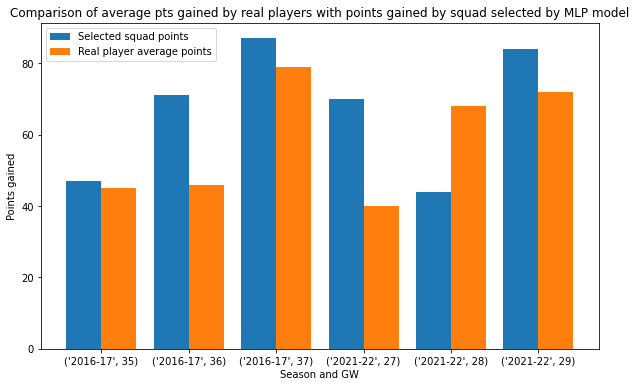

In [55]:
plt.figure(figsize=(10,6))

X_axis = np.arange(len(gameweeks))

plt.bar(X_axis - 0.2, selected_squad_points_mlp, 0.4, label = 'Selected squad points')
plt.bar(X_axis + 0.2, real_player_average_points, 0.4, label = 'Real player average points')

plt.xticks(X_axis, gameweeks)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of average pts gained by real players with points gained by squad selected by MLP model")
plt.legend()
plt.show()

In [56]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp))
print('Sum of points gained by real players:', sum(real_player_average_points))
print('Difference:', sum(selected_squad_points_mlp) - sum(real_player_average_points), 'pts')

Sum of points gained by selected squad: 403.0
Sum of points gained by real players: 350
Difference: 53.0 pts


### Evaluate XGB model for whole test_subset

In [ ]:
gameweeks = []
for season in test_subset:
    for gameweek in season[1]:
        results.append(squad_selection_without_constraints(predictions_merged_xgb, season[0], gameweek))
        gameweeks.append((season[0], gameweek))

selected_squad_points_xgb = []
for result in results:
    selected_squad_points_xgb.append(result[1])

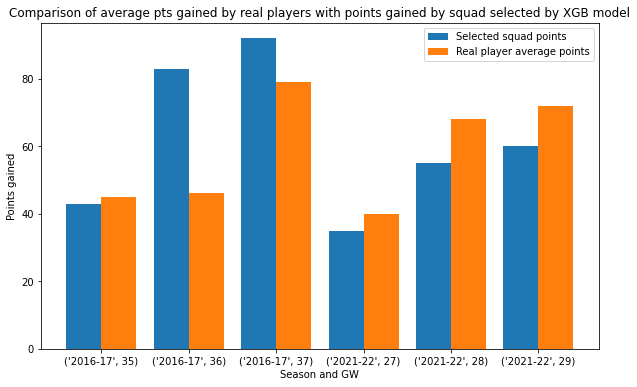

In [59]:
plt.figure(figsize=(10,6))

X_axis = np.arange(len(gameweeks))

plt.bar(X_axis - 0.2, selected_squad_points_xgb, 0.4, label = 'Selected squad points')
plt.bar(X_axis + 0.2, real_player_average_points, 0.4, label = 'Real player average points')

plt.xticks(X_axis, gameweeks)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of average pts gained by real players with points gained by squad selected by XGB model")
plt.legend()
plt.show()

In [61]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_xgb))
print('Sum of points gained by real players:', sum(real_player_average_points))
print('Difference:', sum(selected_squad_points_xgb) - sum(real_player_average_points), 'pts')

Sum of points gained by selected squad: 368.0
Sum of points gained by real players: 350
Difference: 18.0 pts


### Conclusion
These results look promising. Squad selected by AI MLP model seems to gain more points than real players on average. With this test_subset, XGBoost model gained significantly lower amount of points than MLP model, but still more than real average FPL player. But we need to notice that it just simple initial comparison. Predictions are taken from simple baseline model without any price constraints and we tested it only on 6 gameweeks. So it is not very accurate at this moment, but it's a great step towards main goal of this project, which is AI model that can achieve better results than average real player during the whole FPL season.

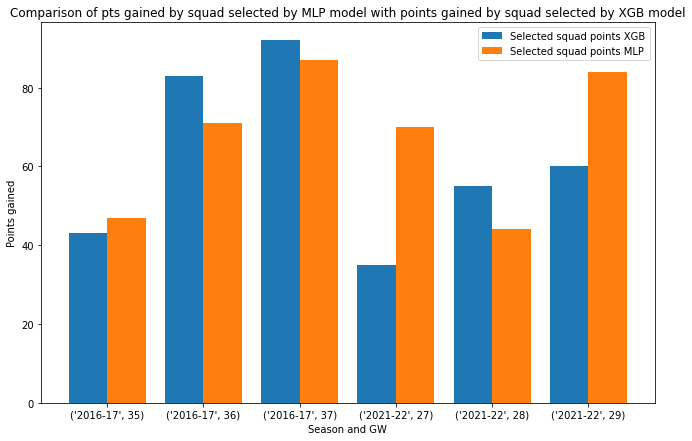

In [64]:
plt.figure(figsize=(11,7))

X_axis = np.arange(len(gameweeks))

plt.bar(X_axis - 0.2, selected_squad_points_xgb, 0.4, label = 'Selected squad points XGB')
plt.bar(X_axis + 0.2, selected_squad_points_mlp, 0.4, label = 'Selected squad points MLP')

plt.xticks(X_axis, gameweeks)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model")
plt.legend()
plt.show()

In [57]:
# run evaluation on test_subset and log results to mlflow
evaluate_selected_squad_without_constraints(predictions_merged_mlp, test_subset, 'mlp_model_06-07-22')
evaluate_selected_squad_without_constraints(predictions_merged_xgb, test_subset, 'xgb_model_06-07-22')